# Import necessary modules and models.

* Models are defined in model.py.
* DigitClassifierCNN is parameterized:
  - apply_batch_norm
  - apply_dropout
  - CNN kernel/padding/stride
  - fc1, fc2 hidden units

In [11]:
import os

# Pytorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

import torchvision
from torchvision.transforms import v2
from torchvision.datasets import MNIST
from torch.utils.data import random_split, DataLoader

# Tuning modules

from ray import tune
from ray import train
from ray.train import Checkpoint, session
from ray.tune.schedulers import ASHAScheduler


# Set device and seed
device = "cuda:0" if torch.cuda.is_available() else "cpu"

torch.manual_seed(123)

In [12]:
# Import parameterized model
from model import DigitClassifierCNN

digit_classifier = DigitClassifierCNN(apply_batch_norm=True, apply_dropout=True, ch1=32,
                                      kernel=5, l1=16, l2=16)

digit_classifier.to(device)

summary(digit_classifier, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Compose-1            [-1, 1, 28, 28]               0
            Conv2d-2           [-1, 32, 24, 24]             832
       BatchNorm2d-3           [-1, 32, 24, 24]              64
         MaxPool2d-4           [-1, 32, 12, 12]               0
            Conv2d-5             [-1, 64, 8, 8]          51,264
       BatchNorm2d-6             [-1, 64, 8, 8]             128
         MaxPool2d-7             [-1, 64, 4, 4]               0
           Dropout-8                 [-1, 1024]               0
            Linear-9                   [-1, 16]          16,400
      BatchNorm1d-10                   [-1, 16]              32
           Linear-11                   [-1, 16]             272
      BatchNorm1d-12                   [-1, 16]              32
          Dropout-13                   [-1, 16]               0
           Linear-14                   

In [55]:
# Test random 28x28 input

# BatchNorm2D layer throws an error if we give a sample size of 1.
i = torch.randn(2, 1, 28, 28).to(device)

out = digit_classifier(i)
print(out)

tensor([[-0.0404,  0.9648, -0.1775,  1.4439, -0.6228,  0.2511,  0.8285, -1.0714,
         -1.2915, -0.6207],
        [ 0.3015, -0.1213,  0.1463,  0.0734,  0.0025, -0.3841,  0.1672,  0.0262,
          0.2432,  0.2931]], device='cuda:0', grad_fn=<AddmmBackward0>)


# Data loading and exploration

* Load data from MNIST. Normalize and split into train/val/test sets.
* Visualize some examples from the dataset for each number.

In [32]:
def load_data(data_dir="./data/", batch_size=8):
    # Normalization values found on web
    data_transform = v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize((0.1307,), (0.3081,))
    ])

    data = MNIST(data_dir, train=True,
                 download=True, transform=data_transform)
    train_data, val_data = torch.utils.data.random_split(data, [50000, 10000])
    test_data = MNIST(data_dir, train=False,
                      download=True, transform=data_transform)

    train_dataloader = DataLoader(train_data,
                                  batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_data,
                                batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data,
                                 batch_size=batch_size, shuffle=True)

    return train_dataloader, val_dataloader, test_dataloader


train_dataloader, val_dataloader, test_dataloader = load_data()

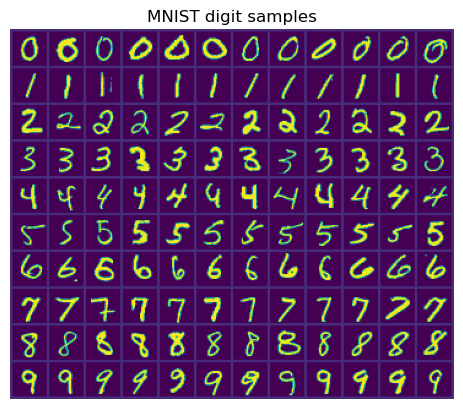

In [41]:
import matplotlib.pyplot as plt
import numpy as np


def matplotlib_imshow(img, labels, title=""):
    img = img.mean(dim=0)
    img = img.cpu()
    npimg = img.numpy()
    plt.axis('off')
    plt.imshow(npimg)
    plt.title(title)


# Pull samples for each label
digits = list(range(10))
digits_samples = [[] for i in range(10)]
sample_size = 12

while not all([len(i) == sample_size for i in digits_samples]):
    imgs, labels = next(iter(train_dataloader))
    for i, l in enumerate(labels):
        if len(digits_samples[int(l)]) < sample_size:
            digits_samples[int(l)].append(imgs[i])


digits_samples = [i for s in digits_samples for i in s]  # flatten the samples
img_grid = torchvision.utils.make_grid(digits_samples, nrow=sample_size)
matplotlib_imshow(img_grid, labels, title="MNIST digit samples")

# Set up tensorboard logging.

In [42]:
from torch.utils.tensorboard import SummaryWriter

# Default log_dir argument is "runs" - but it's good to be specific
# torch.utils.tensorboard.SummaryWriter is imported above
writer = SummaryWriter('runs/mnist_digit_classification')

# Write image data to TensorBoard log dir
writer.add_image('MNIST digit samples', img_grid)
writer.flush()

# To view, start TensorBoard on the command line with:
#   tensorboard --logdir=runs
# ...and open a browser tab to http://localhost:6006/

# Training loop

Use `train_one_epoch` inside a larger `train_mnist` function. Make sure to set up configs for hyperparameter search.

In [43]:
import torch.optim as optim

def train_one_epoch(model, epoch_index, optimizer, criterion, verbose=True):
    model.train()
    
    running_loss = 0.
    last_loss = 0.
    
    for i, (x, y) in enumerate(train_dataloader):

        x, y = x.to(device), y.to(device)
        
        # Compute gradients and update for each minibatch
        optimizer.zero_grad()   #
        y_hat = model(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()    # Does the update
        
        # Log every 1000
        running_loss += loss.item()
        
        if i % 1000 == 999:
            last_loss = running_loss / 1000
            
            # Calculate validation loss.
            
            val_loss = 0.
            
            for i, (x, y) in enumerate(val_dataloader):
                with torch.no_grad():
                    x, y = x.to(device), y.to(device)
                    y_hat = model(x)
                    val_loss += criterion(y_hat, y).item()
                    
            val_loss /= len(val_dataloader.dataset)
                
            if verbose:
                print("    batch: {}  train loss: {}  val loss: {}".format(i+1, last_loss, val_loss))
            
            running_loss = 0.
            
        
    return last_loss, val_loss

In [54]:
def train_mnist(config, data_dir="./data", verbose=True):
    # define model
    model = DigitClassifierCNN(
        apply_batch_norm=config["apply_batch_norm"],
        apply_dropout=config["apply_dropout"],
        ch1=config["ch1"],
        kernel=config["kernel"],
        l1=config["l1"],
        l2=config["l2"]
    )

    # move to gpu if available
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
    model.to(device)

    # set up optimizer and loss functions
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    # Checkpoint
    checkpoint = train.get_checkpoint()

    if checkpoint:
        with checkpoint.as_directory() as checkpoint_dir:
            checkpoint_dict = torch.load(
                os.path.join(checkpoint_dir, "checkpoint.pt"))

        start_epoch = checkpoint_dict["epoch"]
        model.load_state_dict(checkpoint_dict['model_state'])
        optimizer.load_state_dict(checkpoint_dict['optimizer_state'])
    else:
        start_epoch = 0

    # load data
    train_dataloader, val_dataloader, test_dataloader = load_data()

    # train multiple epochs
    for epoch in range(10):
        if verbose:
            print(f"Epoch: {epoch}")
        train_loss, val_loss = train_one_epoch(
            model, epoch, optimizer, criterion, verbose)

        # Calculate train/validation accuracy at the end of each epoch
        train_accuracy, _, _ = get_accuracy(model, train_dataloader)
        val_accuracy, _, _ = get_accuracy(model, val_dataloader)

        if verbose:
            print(f"  train_accuracy: {train_accuracy}")
            print(f"  val_accuracy: {val_accuracy}")

        # Make a checkpoint
        os.makedirs("models", exist_ok=True)
        torch.save(
            (model.state_dict(),
             optimizer.state_dict()),
            "models/checkpoint.pt")
        checkpoint = Checkpoint.from_directory("models")

        train.report({
                "val_accuracy": val_accuracy,
                "train_accuracy": train_accuracy,
                "val_loss": val_loss,
                "train_loss": train_loss
            },
            checkpoint=checkpoint
        )

    return model, {
        "val_accuracy": val_accuracy,
        "train_accuracy": train_accuracy,
        "val_loss": val_loss,
        "train_loss": train_loss
    }

In [83]:
# Error analysis

def get_accuracy(model, dataloader):

    img_errors = torch.empty(0, dtype=torch.int64).to(device)
    true_labels = torch.empty(0, dtype=torch.int64).to(device)
    labels_errors = torch.empty(0, dtype=torch.int64).to(device)

    total = 0
    correct = 0
    with torch.no_grad():
        for i, (imgs, labels) in enumerate(dataloader):
            imgs, labels = imgs.to(device), labels.to(device)

            pred = model(imgs)
            pred_labels = torch.argmax(pred, axis=1)
            img_errors = torch.cat((img_errors, imgs[labels != pred_labels]), 0)
            true_labels = torch.cat((true_labels, labels[labels != pred_labels]), 0)
            labels_errors = torch.cat((labels_errors, pred_labels[labels != pred_labels]), 0)

    return 1 - img_errors.shape[0]/len(dataloader.dataset), img_errors, labels_errors, true_labels


In [73]:
# set search space for config
search_space = {
    # normalization params
    "apply_batch_norm": tune.choice([True, False]),
    "apply_dropout":    tune.choice([True, False]),
    # CNN prams
    "ch1":     tune.choice([2 ** i for i in range(2,5)]),
    "kernel":  tune.choice([3,5]),
    # fc layer dimensions
    "l1": tune.choice([2 ** i for i in range(4,8)]),
    "l2": tune.choice([2 ** i for i in range(4,7)])
}

search_space['ch1']

In [74]:
def test_best_model(best_result):
    best_trained_model = DigitClassifierCNN(
        apply_batch_norm=best_result.config["apply_batch_norm"], 
        apply_dropout=best_result.config["apply_dropout"],
        ch1=best_result.config["ch1"], 
        kernel=best_result.config["kernel"],
        l1=best_result.config["l1"], 
        l2=best_result.config["l2"]
    )
    
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    best_trained_model.to(device)

    checkpoint_path = os.path.join(best_result.checkpoint.to_directory(), "checkpoint.pt")

    model_state, optimizer_state = torch.load(checkpoint_path)
    best_trained_model.load_state_dict(model_state)

    _, val_loader, test_loader = load_data()

    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = best_trained_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print("Best trial test set accuracy: {}".format(correct / total))

    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = best_trained_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print("Best trial test set accuracy: {}".format(correct / total))



In [75]:
num_samples = 50

data_dir = os.path.abspath("./data")

scheduler = ASHAScheduler(
    metric="val_accuracy",
    max_t=15,
    grace_period=1,
    reduction_factor=2,
)

tuner = tune.Tuner(
    tune.with_resources(
        tune.with_parameters(train_mnist, data_dir=data_dir, verbose=False),
        resources={"cpu": 2, "gpu": 1}
    ),
    param_space=search_space,
    tune_config=tune.TuneConfig(
        mode="min",
        num_samples=num_samples,
        scheduler=scheduler
    )
)

results = tuner.fit()

best_result = results.get_best_result("val_accuracy", "min")
print(f"Best trial config: {best_result.config}")
print(f"Best trial final validation accuracy: {best_result.metrics['val_accuracy']}")
print(f"Best trial final validation loss: {best_result.metrics['val_loss']}")

test_best_model(best_result)

2023-11-21 09:55:52,429	WARNING tune.py:186 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2023-11-21 09:56:03,305	WARNING worker.py:2074 -- Warning: The actor ImplicitFunc is very large (91 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
2023-11-21 09:56:06,349	INFO tune.py:1047 -- Total run time: 16.21 seconds (13.01 seconds for the tuning loop).
2023-11-21 09:56:06,349	WARNING tune.py:1062 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: Tuner.restore(path="/home/sica/ray_results/train_mnist_2023-11-21_09-55-50", trainable=...)
2023-11-21 09:56:06,354	WARNING experiment_analysis.py:185 -- Failed to fetch metrics for 17 trial(s):
- train_mnist_34dfa_00000: FileNotFoundError('Could

RuntimeError: No best trial found for the given metric: val_accuracy. This means that no trial has reported this metric, or all values reported for this metric are NaN. To not ignore NaN values, you can set the `filter_nan_and_inf` arg to False.

In [60]:
best_result

Result(
  metrics={'val_accuracy': 0.7136, 'train_accuracy': 0.7152000000000001, 'val_loss': 0.10570774457007646, 'train_loss': 0.8409449143260718},
  path='/home/sica/ray_results/train_mnist_2023-11-20_18-00-47/train_mnist_c9f56_00033_33_apply_batch_norm=True,apply_dropout=True,ch1=4,kernel=5,l1=16,l2=16_2023-11-20_18-46-41',
  filesystem='local',
  checkpoint=Checkpoint(filesystem=local, path=/home/sica/ray_results/train_mnist_2023-11-20_18-00-47/train_mnist_c9f56_00033_33_apply_batch_norm=True,apply_dropout=True,ch1=4,kernel=5,l1=16,l2=16_2023-11-20_18-46-41/checkpoint_000009)
)

In [ ]:
a = [[1,2], [3,4], [5,6], [7,8]]
b = [[1,2], [3,4], [5,6], [7,8]]

for data in a:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    outputs = best_trained_model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()


In [76]:
config = {
    "apply_batch_norm": False,
    "apply_dropout": False,
    "ch1": 8,
    "kernel": 5,
    "l1": 16, 
    "l2": 64
}

model, metrics = train_mnist(config, data_dir="./data", verbose=True)
test_best_model(model)

Epoch: 0
    batch: 1250  train loss: 0.5212765301060863  val loss: 0.02891195922731422
    batch: 1250  train loss: 0.19449579990393248  val loss: 0.01748082245210535
    batch: 1250  train loss: 0.14931381921228604  val loss: 0.014162507948558778
    batch: 1250  train loss: 0.12366114978981205  val loss: 0.012695838647792697
    batch: 1250  train loss: 0.10677053622840321  val loss: 0.010222459296484158
    batch: 1250  train loss: 0.0946641582059674  val loss: 0.009994445438258481
  train_accuracy: 0.97376
  val_accuracy: 0.9733
Epoch: 1
    batch: 1250  train loss: 0.0889669902292153  val loss: 0.00842758798233117
    batch: 1250  train loss: 0.07639466222296323  val loss: 0.00863496821664885
    batch: 1250  train loss: 0.08362287013359673  val loss: 0.008432393001260061
    batch: 1250  train loss: 0.07484208950991887  val loss: 0.00699721734606901
    batch: 1250  train loss: 0.07035780889326634  val loss: 0.008753683988317062
    batch: 1250  train loss: 0.0645873827529249  v

AttributeError: 'DigitClassifierCNN' object has no attribute 'config'

In [84]:
test_acc, _, _, _ = get_accuracy(model, test_dataloader)
val_acc, val_misclassified, val_pred_labels, val_true_labels = get_accuracy(model, val_dataloader)

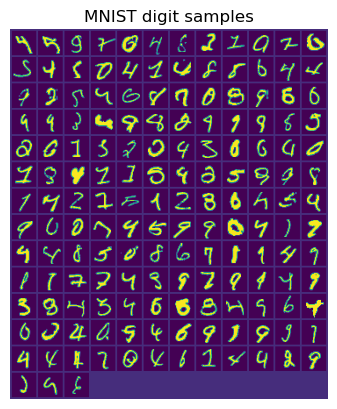

In [86]:
# Pull samples for each label
        
img_grid = torchvision.utils.make_grid(val_misclassified, nrow=sample_size)
matplotlib_imshow(img_grid, val_pred_labels, title="MNIST digit samples")